# Fast-forwarded Trotter Circuits for Quantum Simulation of XXZ spin chain.

In [7]:
# Authors: Anirban Mukherjee
# Version: 1.0 (05/20/2022)
# License: MIT
# Email: amukh1290@gmail.com
# Tested on Windows 10 running Python 3.8.12 with the following packages:
# numpy = 1.21.2, scipy =  1.7.3, matplotlib = 3.5.0, qiskit =0.19.1 , openfermion =1.0.1 

## Overview


In this notebook we construct quantum circuits to simulate quantum dynamics of spin chains. We discuss different variants of the Trotterized time evolution of <a href="https://dylanvanzyl.com/wp-content/uploads/2019/01/Introduction-to-Heisenberg-spin-chains-new.pdf">quantum spin chains</a> in one  dimension. We aim  to find the shortest depth Trotter circuit that can simulate the time evolution  of Haar random quantum states with the best possible fidelity. The reference states at time (t=0)  are initialized via random Quantum circuits. Multiple realization of the random circuits are sampled and a measure of **average fidelity** of the time evolved state is defined to quantify the efficiency of the different Trotter circuits. <br>
<par>
This topic is motivated by the <a href="https://research.ibm.com/blog/quantum-open-science-prize">ibm open science prize competition 2021 </a>, **however in the present notebook the focus is a bit different and that is to study how <span style="color:#FFA500">Quantum Resources</span> scale with number of qubits for different variants of the Trotter circuits. More precisely we consider two kinds of Trotter circuits:** <br>(i) <span style="color:#4285F4">conventional first-order Trotter decomposition of the time evolution operator with the Heisenberg or XXZ Hamiltonian.</span> <br>(ii)<span style="color:#0F9D58">Fast forwarded Trotter Circuit where the XY part of the spin chain Hamiltonian is diagonalized using Givens rotation.</span><br>
<br>
The simulations below can be carried out for an arbitrary number of qubits, in this notebook we have carried out a simulation for **num. of qubits=3,4,5,6,7,8**. We check the **number of CNOT gates** required to perform **high fidelity** quantum dynamics simulation of XXZ spin chains for number of qubits 3,4,5,6,7,8 and for **total evolution time of T=70 secs** with a **average fidelity above 99.9%**.

In [8]:
# imports
import warnings
warnings. filterwarnings('ignore')
import numpy
import copy
from openfermion.linalg import givens_decomposition_square as givensRotns
import numpy as np
import qiskit
from itertools import cycle
from qiskit.visualization.circuit_visualization import circuit_drawer
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import MCMT
from qpsolvers import solve_qp
from  qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators import op_converter
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit.aqua.operators.legacy.op_converter import to_weighted_pauli_operator
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.optimizers import L_BFGS_B
from qiskit import Aer
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.circuit.random import random_circuit
from qiskit import QuantumRegister, QuantumCircuit, execute
import scipy
from time import time
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector

In [9]:
from IPython.display import HTML
js = r""" <script type="text/Javascript"> MathJax.Hub.Config({ TeX: { equationNumbers: { autoNumber: "AMS", useLabelIds: true } }});
</script> """
HTML(js)

## The XXZ Spin Chain Hamiltonian

The <a href="https://dylanvanzyl.com/wp-content/uploads/2019/01/Introduction-to-Heisenberg-spin-chains-new.pdf">XXZ Spin Chain Hamiltonian</a> describes the nature of interaction between nearest neighbor spins on a 1D lattice with periodic boundary conditions
<img src='images/XXZ-Hamiltonian.png' width='400'><br>
Here X, Y and Z are <a href='https://en.wikipedia.org/wiki/Pauli_matrices'>Pauli Operators</a>. Here i,i+1 are the spin indexes on which the Pauli operators are acting. We study open boundary condition. In this notebook we will write the code for arbitrary $N$ and compare the quantum circuit resources between standard Trotter Circuit and fast-forwarded Trotter circuits respectively. 

In [4]:
def XXZhamiltonian(Jxy,Jz,num_qubits):
    '''
    Jxy:coupling of the \sum_{ij}Jxy(X_iX_j+Y_iY_j) part of the Hamiltonian
    Jzz:coupling of the \sum_{ij}JzzZ_iZ_j part of the Hamiltonian
    num_qubits: number of qubits
    output: XXZ spin chain Hamiltonian
    '''
    qH=PauliSumOp.from_list([['I'*num_qubits,0]])
    for i in range(num_qubits-1):
        PauliStr='I'*num_qubits
        PauliXX=numpy.array(list(PauliStr))
        PauliXX[i]=PauliXX[i+1]='X'
        PauliXX=''.join(PauliXX)
        PauliYY=numpy.array(list(PauliStr))
        PauliYY[i]=PauliYY[i+1]='Y'
        PauliYY=''.join(PauliYY)
        PauliZZ=numpy.array(list(PauliStr))
        PauliZZ[i]=PauliZZ[i+1]='Z'
        PauliZZ=''.join(PauliZZ)
        qH=qH+PauliSumOp.from_list([[PauliXX,Jxy],[PauliYY,Jxy],[PauliZZ,Jz]])
    qH=qH.reduce()
    return qH 

## 1. <span style="color:#4285F4">First Order Conventional Trotter Circuit for the XXZ Spin Chain</span>
Given the Hamiltonian $H$ we can simulate the time dynamics of the quantum system by solving the time-dependent Schrodinger equation
\begin{equation*}
H|\Psi\rangle = i\hbar\frac{d}{dt}|\Psi\rangle\label{TDSE}\tag{1}
\end{equation*}
Upon solving the equation we get,
\begin{equation*}
|\Psi(T)\rangle = e^{iHT}|\Psi(0)\rangle\label{TimeEvolution}\tag{2}
\end{equation*}
 
<img src='images/xxz-spin-chain.png' width='700'><br>
**Fig. 1.** The figure represents the n spin XXZ model with OBC.
<br>
For a n spin XXZ Hamiltonian with **open boundary condition(OBC)** the exponential time evolution operator can be represented as,
<img src='images/fullTimeEvolutionOperatorXXZ.png' width='400' height='200'><br>
For implementing the unitary evolution U(T) over (0,T) using quantum circuits the evolution is boken into N Trotter steps over time intervals: (0,t),(t,2t),...., ((N-1)t,T) here Nt=T. The gate arrangement in a single Trotter step invoves first the action of **ZZ gates** on ref state then **XX and YY rotations** of  pairs of qubits on **even bonds** and then over **odd bonds**.
<img src='images/expression1.png' width='900'><br>
The above single Trotter step circuit approximates the time evolution operator as follows:
<img src='images/Trotter-error.png' width='350'><br>

In [5]:
def circuit_formatter(qc,file_name):
    '''
    qc:QuantumCircuit ibject of qiskit
    file_name: saving the circuitdraw object as .png
    output: circuit drawing
    '''
    Draw_circ=circuit_drawer(qc,scale=1.5,style={'fontsize':8.5,'latexdrawerstyle':True,'gatetextcolor':'#000000','gatefacecolor':'#B7E9C1','backgroundcolor':'#f2f2f2'},output='mpl',filename='./%s.png'%(file_name))
    return Draw_circ
def group_H_terms(qH):
    '''
    qH:PauliSumOp object qubit Hamiltonian XXZ 
    output: H can be written as a mutually commuting sum of H_j as H=H_1+H_2+H_3+....
            the return variable groups is an array of Hamiltonian subparts [H_1,H_2,],
            within each group the terms are commuting.
    '''
    qubitH=WeightedPauliOperator([[qH.primitive.coeffs[i],qH.primitive.paulis[i]] for i in range(len(qH.primitive.paulis))])
    Paulis=qubitH.paulis
    individual_ops=[WeightedPauliOperator([Paulis[i]]) for i in range(len(Paulis))]
    groups=[individual_ops[0]]
    for i in range(1,len(individual_ops)):
        flag=True
        for j in range(len(groups)):
            if groups[j].commute_with(individual_ops[i])==True:
                groups[j].add(individual_ops[i])
                flag=False
        if flag==True:
            groups.append(individual_ops[i])
    new_group=[]        
    for i in range(len(groups)):
        Paulis=groups[i].paulis
        split_op=[]
        for j in range(len(Paulis)):
            split_op.append(PauliSumOp.from_list([[Paulis[j][1].to_label(),Paulis[j][0]]]))
        new_group.append(split_op)  
        group=new_group
    return group
def FirstOrderTrotterCircuit(qH,T,t):
        '''
        qH:PauliSumOp object qubit Hamiltonian XXZ 
        T: Total evolution period
        t: small time interval in which the Trotter circuit is implemented.
        output: The first order Trotter circuit for the Hamiltonian
        '''  
        def MQgate(PauliOp,t):
            PauliStr=PauliOp.primitive.paulis[0].to_label()
            coeff=PauliOp.primitive.coeffs[0]
            PauliStrArr=numpy.array(list(PauliStr))
            qubits_with_nonId_ops=numpy.where(PauliStrArr!='I')[0]
            PauliSubStr=''.join(PauliStrArr[qubits_with_nonId_ops])
            U=PauliSumOp.from_list([['I'*len(qubits_with_nonId_ops),numpy.cos(coeff*t)],[PauliSubStr,-1j*numpy.sin(coeff*t)]])
            Coupling='J_{z}' if PauliSubStr=='ZZ' else 'J_{xy}'
            Umat=PauliSumOp.from_list([['I'*num_qubits,numpy.cos(coeff*t)],[PauliStr,-1j*numpy.sin(coeff*t)]]).to_matrix()
            Ugate=U.to_circuit().to_gate(label=r'$\exp(-i'+Coupling+PauliSubStr+'t'+')$')
            return Ugate,Umat,qubits_with_nonId_ops
        num_qubits=qH.num_qubits
        grouped_qH=group_H_terms(qH)
        qc=QuantumCircuit(qr)
        qc1=qc.copy()
        U_trotter_mat=numpy.eye(2**num_qubits)
        for j in range(len(grouped_qH)):
                for k in range(len(grouped_qH[j])):
                    Ugate,Umat,qubits_with_nonId_ops=MQgate(grouped_qH[j][k],t)
                    U_trotter_mat=U_trotter_mat@Umat
        N=int(T/t)
        U_T=numpy.linalg.matrix_power(U_trotter_mat, N)
        qc1.unitary(U_T,qr,label=r'1stOrdTrotterGate-%s slices'%str(N))
        
        for j in range(len(grouped_qH)):
            for k in range(len(grouped_qH[j])):
                Ugate,Umat,qubits_with_nonId_ops=MQgate(grouped_qH[j][k],t)
                qr_inds=[qr[i] for i in qubits_with_nonId_ops]
                qc.append(Ugate,qr_inds)
        return qc,qc1

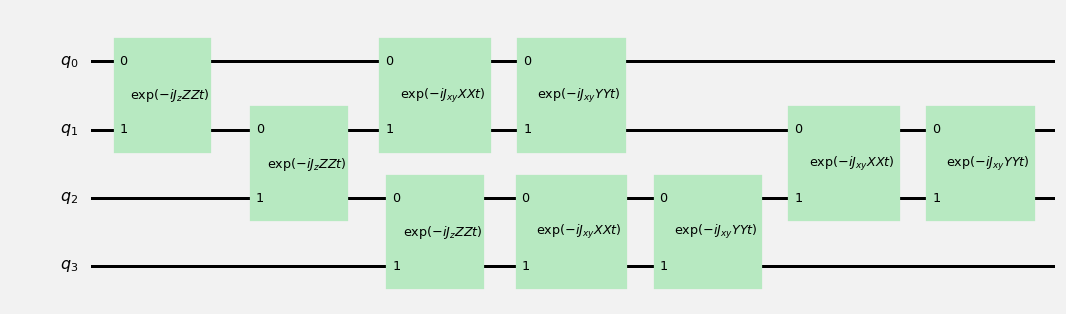

In [6]:
T=0.1
t=0.1
num_qubits=4
qH=XXZhamiltonian(1,1,num_qubits)
qr=QuantumRegister(num_qubits,'q')
qc_single,qc_fulltime=FirstOrderTrotterCircuit(qH,T,t)
circuit_formatter(qc_single,"single-conv-Trotter-step-4-qubit-XXZ-OBC")

## 2. <span style="color:#0F9D58">Fast forward Trotter Circuit for the XXZ Spin Chain</span>

### (a)Fast forward Trotter for XXZ spin chain 
The XXZ spin chain Hamiltonian can be decomposed into the XY part and the ZZ part
<img src='images/diagAndOffDiag.png' width='700'><br>
The **XY** terms do no commute with the **ZZ** terms leading to a Trotter error proportional to O(tJxyJzz) upon splitting within the exponential.  Similarly the  **XX and YY rotations** on **even bonds*,   do not commute with YY rotations on **odd bonds**, this leads to a Trotter error of order O(tJxy^2). It would have been convenient if we found a unitary operation ($U_{XY}$) implemented via a hardware efficient quantum circuit such that $H_{XY}$ is rendered diagonal, then we can get rid of one source of Trotter error i.e. O(tJxy^2) in e^iHT:<br>
<img src='images/unitaryDiagH_XY.png' width='250'><br>
where $D_{XY}$ is some diagonal operator that can be purely written in terms of Z Pauli operators. With this we present below a fast forwarded Quantum dynamical simulation circuit that is exact,
<img src='images/fast-trotter.png' width='550'><br>
The circuit construction for diagonalizing the XY part of the Hamiltonian is shown below: 

In [182]:
def XYspinChainFromSpinlessFermions(h1):
    '''
    The function takes input the electron hopping matrix performs jordan wigner and freezes one set of degree of freedom 
    leading to a spin model. This is equivalent to the mapping between 1D XY model and a model of spinless fermions.
    '''
    num_qubits=len(h1)
    h2=numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))
    fer_op=FermionicOperator(h1,h2)
    fer_op=fer_op.fermion_mode_elimination(num_qubits//2+numpy.arange(num_qubits//2))
    qubit_op=fer_op.mapping('jordan_wigner')
    qubit_op=PauliSumOp.from_list([[op[1].to_label(),op[0]] for op in qubit_op.paulis])
    return qubit_op
def XY_diag_circuits(num_qubits):
        '''
        This function takes imput the 1d hopping matrix and using openfermion we extract the givens rotation angles. 
        When the associated two qubit rotations are implemented then in that basis we can render the Hamiltonian  
        '''
        def MQgate(PauliStr,theta):
            PauliStrArr=numpy.array(list(PauliStr))
            qubits_with_nonId_ops=numpy.where(PauliStrArr!='I')[0]
            PauliSubStr=''.join(PauliStrArr[qubits_with_nonId_ops])
            U=PauliSumOp.from_list([['I'*len(qubits_with_nonId_ops),numpy.cos(theta)],[PauliSubStr,1j*numpy.sin(theta)]])
            Ugate=U.to_circuit().to_gate(label=r'$\exp(-i'+'{:.2f}'.format(theta)+List[0][0]+')$')
            return Ugate,qubits_with_nonId_ops
        h=numpy.zeros((num_qubits,num_qubits))
        for i in range(num_qubits-1):
            h[i,i+1]=h[i+1,i]=2
        qubitH=XYspinChainFromSpinlessFermions(numpy.block([[h,numpy.zeros((num_qubits,num_qubits))],
                                                            [numpy.zeros((num_qubits,num_qubits)),numpy.zeros((num_qubits,num_qubits))]]))
        #qubitH2=qubitH.copy()
        w,v=numpy.linalg.eigh(h)
        rotH=FermionicOperator(numpy.diag(w),numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))).mapping('jordan_wigner')
        rotH=PauliSumOp.from_list([[op[1].to_label(),op[0]] for op in rotH.paulis])
        givens=givensRotns(v.T)[0]
        Op=PauliSumOp.from_list([['I'*num_qubits,1]])
        OpMat=numpy.eye(2**num_qubits)
        Uarr=[]
        circ=QuantumCircuit(num_qubits)
        for rots in givens:
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((2*num_qubits,2*num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=XYspinChainFromSpinlessFermions(h1)
                List=qubit_h1.primitive.to_list()
                Op1=[('I'*num_qubits,numpy.cos(theta*List[0][1])),(List[0][0],1j*numpy.sin(theta*List[0][1]))]
                Op2=[('I'*num_qubits,numpy.cos(theta*List[1][1])),(List[1][0],1j*numpy.sin(theta*List[1][1]))]
                Op1=PauliSumOp.from_list(Op1)
                Op2=PauliSumOp.from_list(Op2)
                Op=Op2@Op1@Op
                OpMat=Op2.to_matrix()@Op1.to_matrix()@OpMat
                Op=Op.reduce()
                U1,qubits_acted_upon=MQgate(List[0][0],theta)
                U2,qubits_acted_upon=MQgate(List[1][0],theta)
                qr_inds=[qr[i] for i in qubits_acted_upon]
                circ.append(U1,qr_inds)
        return circ,Op,OpMat,rotH

In [183]:
#demonstrating the Hailtonian diagonalization
num_qubits=4
U_XY_circ,U_XY,U_XY_mat,rotH_XY=XY_diag_circuits(num_qubits)
print("rotated XY Hamiltonian to diag rep.\n",rotH_XY)
print("reconstruct XY Hamiltonian using unitaries\n",(U_XY@rotH_XY@U_XY.adjoint()).reduce())
print("original XY Hamiltonian\n",qH[num_qubits-1:])

rotated XY Hamiltonian to diag rep.
 1.6180339887498947 * IIIZ
+ 0.6180339887498946 * IIZI
- 0.6180339887498952 * IZII
- 1.6180339887498942 * ZIII
reconstruct XY Hamiltonian using unitaries
 0.9999999999999993 * XXII
+ 0.9999999999999993 * YYII
+ 0.9999999999999988 * IXXI
+ 0.999999999999999 * IYYI
+ 0.9999999999999991 * IIXX
+ 0.9999999999999996 * IIYY
original XY Hamiltonian
 1.0 * XXII
+ 1.0 * YYII
+ 1.0 * IXXI
+ 1.0 * IYYI
+ 1.0 * IIXX
+ 1.0 * IIYY


Below we present the Givens rotation circuit for diagonalizing XY part of the Hamiltonian

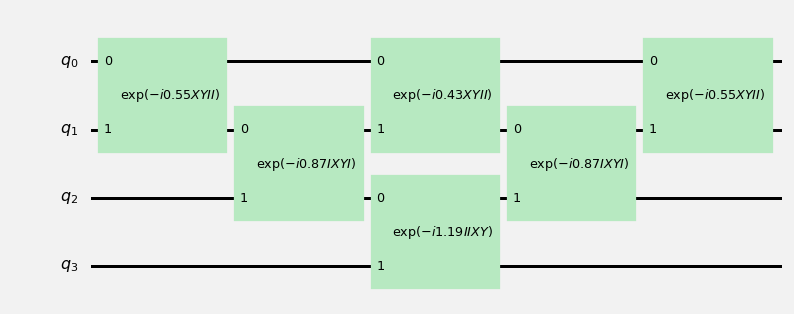

In [9]:
circuit_formatter(U_XY_circ,"Givens Rotn circuit for diagonalizing XY part of H")

In [10]:
def Fast_forwardedTrotterCircuit(qH_ZZ,U_XY_circ,U_XY_mat,rotH_XY,T,t):
        '''
        qH_ZZ: ZZ part of XXZ Hamiltonian, \sum_{j}Z_{j}Z_{j+1}
        U_XY: unitary rotation that diagonalizes the \sum_{i}X_{i}X_{i+1}+Y_{i}Y_{i+1} Hamiltonian
        qH_ZZ: ZZ part of XXZ Hamiltonian, \sum_{j}Z_{j}Z_{j+1}
        T: total evolution time
        t: trotter time step
        output: Fast forwarded Trotter circuit.
        '''
        def MQgate(PauliOp,t):
            PauliStr=PauliOp.primitive.paulis[0].to_label()
            coeff=PauliOp.primitive.coeffs[0]
            PauliStrArr=numpy.array(list(PauliStr))
            qubits_with_nonId_ops=numpy.where(PauliStrArr!='I')[0]
            PauliSubStr=''.join(PauliStrArr[qubits_with_nonId_ops])
            U=PauliSumOp.from_list([['I'*len(qubits_with_nonId_ops),numpy.cos(coeff*t)],[PauliSubStr,-1j*numpy.sin(coeff*t)]])
            Umat=PauliSumOp.from_list([['I'*num_qubits,numpy.cos(coeff*t)],[PauliStr,-1j*numpy.sin(coeff*t)]]).to_matrix()
            Ugate=U.to_circuit().to_gate(label=r'$\exp('+'{:.2f}'.format(-1j*coeff)+PauliSubStr+'t'+')$')
            return Ugate,Umat,qubits_with_nonId_ops
        qc=QuantumCircuit(qr)
        qc1=qc.copy()
        N=int(T/t)
        U_trotter_mat=numpy.eye(2**num_qubits)
        for i in range(len(qH_ZZ)):
            Ugate,Umat,qubits_acted_upon=MQgate(qH_ZZ[i],t)
            qr_inds=[qr[i] for i in qubits_acted_upon]
            qc1.append(Ugate,qr_inds)
            U_trotter_mat=Umat@U_trotter_mat
        U_trotter_mat=U_XY_mat.T.conj()@U_trotter_mat
        qc1.append(U_XY_circ.inverse().to_gate(label='$U_{XY}^{\dag}$'),qr)
        qc1.decompose()
        for i in range(len(rotH_XY)):
            Ugate,Umat,qubits_acted_upon=MQgate(rotH_XY[i],t)
            qr_inds=[qr[i] for i in qubits_acted_upon]
            U_trotter_mat=Umat@U_trotter_mat
            qc1.append(Ugate,qr_inds)
        U_trotter_mat=U_XY_mat@U_trotter_mat
        qc1.append(U_XY_circ.to_gate(label='$U_{XY}$'),qr)
        U_T=numpy.linalg.matrix_power(U_trotter_mat, N)
        qc.unitary(U_T,qr,label=r'1stOrdFastForwardedTrotterGate-%s slices'%str(N))
        return qc1,qc

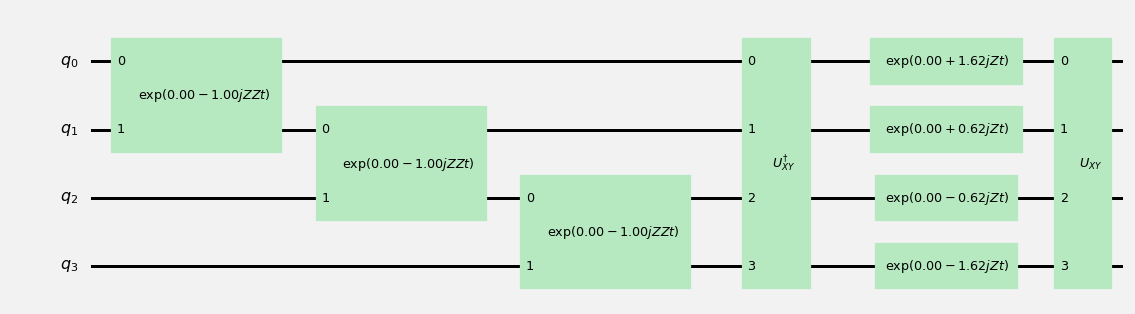

In [184]:
T=0.1
t=0.1
num_qubits=4
qH=XXZhamiltonian(1,1,num_qubits)
qH_ZZ=qH[:num_qubits-1]
qr=QuantumRegister(num_qubits,'q')
qc_single,qc_fulltime=Fast_forwardedTrotterCircuit(qH_ZZ,U_XY_circ,U_XY_mat,rotH_XY,T,t)
circuit_formatter(qc_single,"fast forward Trotter")

In [185]:
def TimeEvolutionOperator(w,v,T):
    '''
    T:Evolution period
    output: exact unitary time evolution matrix
    '''
    return v@numpy.diag(numpy.exp(-1j*w*T))@numpy.conjugate(v.T)

In [186]:
def fidelity_benchmarking_Trotter_circuits(qc_conv_Trotter,qc_fast_Trotter,w,v,T,num_samples):
    '''
    qc_conv_Trotter:conventional first order Trotter Circuit 
    qc_fast_Trotter:fast forwarded Trotter Circuit where the XY part of the Hamiltonian is brought into diagonal
                    representation by Givens Rotations.
    w:eigenvalues of Hamiltonian
    v:eigenvectors of Hamiltonian
    T: evolution time
    num_samples: Number of random initial states over which the average fidelity of the final state is calculated.
    output: average fidelity of the time evolved state
    '''
    fidelity_arr_conv_Trotter=[]
    fidelity_arr_fast_Trotter=[]
    print("Running fidelity test for time evolved states starting for randomly chosen initial states,number of randomly chosen states-%s"%str(num_samples))
    for i in range(num_samples):
        rand_gate=random_circuit(num_qubits,100,seed=i).to_gate(label='ansatz')
        circ=QuantumCircuit(qr)
        circ.append(rand_gate,qr)
        circ1=circ.copy()
        circ1.append(qc_conv_Trotter,qr)
        circ.unitary(TimeEvolutionOperator(w,v,T),qr)
        state=numpy.array(execute(circ,Aer.get_backend('statevector_simulator')).result().get_statevector())
        state1=numpy.array(execute(circ1,Aer.get_backend('statevector_simulator')).result().get_statevector())
        fidelity_arr_conv_Trotter.append(numpy.abs(state@state1.conj())**2)
        circ1=QuantumCircuit(qr)
        circ1.append(rand_gate,qr)
        circ1.append(qc_fast_Trotter,qr)
        state=numpy.array(execute(circ,Aer.get_backend('statevector_simulator')).result().get_statevector())
        state1=numpy.array(execute(circ1,Aer.get_backend('statevector_simulator')).result().get_statevector())
        fidelity_arr_fast_Trotter.append(numpy.abs(state@state1.conj())**2)
        print("fidelity of state from fast order Trotter circuit",fidelity_arr_fast_Trotter[-1],"fidelity of state from 1st order Trotter circuit",fidelity_arr_conv_Trotter[-1])
    return numpy.average(fidelity_arr_fast_Trotter),numpy.average(fidelity_arr_conv_Trotter)    

In [187]:
TimeArr=[10,20,30,40,50,60,70]
def calculateFidelityOverTimeEvolution(num_qubits,Jxy,Jzz,t,TimeArr,num_samples=20):
    '''
    num_qubits: number of qubits
    Jxy: XY coupling
    Jzz: ZZ coupling
    t: Trotter time interval
    TimeArr: Array containing simulation time periods, eg. T=[10,20,30,40,50]
    num_samples: number of random initial states considered for computing average fidelity of time evolved state. Default is 20
    output: output file contains final fidelity of state obtained from Trotterized Circuits over evolution periods in Tarr. 
            Here two types of Trotterized circuits 
           (1) conventional first order Trotter Circuit
           (2) fast forwarded Trotter Circuit where the XY part of the Hamiltonian is brought into diagonal
               representation by Givens Rotations.
    '''
    qH=XXZhamiltonian(Jxy,Jzz,num_qubits)
    w,v=numpy.linalg.eigh(qH.to_matrix())
    qH_ZZ=qH[:num_qubits-1]
    U_XY_circ,U_XY,U_XY_mat,rotH_XY=XY_diag_circuits(num_qubits)
    with open('fidelity_list_Times.txt','a') as f:
        print("num. of qubits-",str(num_qubits),"dt="+'{:.4f}'.format(t),file=f)
        print("time fidelity_fast_Trotter fidelity_conv_Trotter",file=f)
    for T in TimeArr:
        qc_sigle,qc_fast_Trotter=Fast_forwardedTrotterCircuit(qH_ZZ,U_XY_circ,U_XY_mat,rotH_XY,T,t)
        qc_single,qc_conv_Trotter=FirstOrderTrotterCircuit(qH,T,t)
        fidelity_fast_trotter,fidelity_conv_trotter=fidelity_benchmarking_Trotter_circuits(qc_conv_Trotter,qc_fast_Trotter,w,v,T,num_samples)
        with open('fidelity_list_Times.txt','a') as f:
            print(str(T),'   {:.9f}'.format(fidelity_fast_trotter), '   {:.9f}'.format(fidelity_conv_trotter),file=f)

## 3.Results
In this section we study the fidelity of states generated from the two kinds of Trotterized circuits <br>
(1)conventional first order Trotter Circuit,<br>
(2) fast forwarded Trotter Circuit where the XY part of the Hamiltonian is brought into diagonal
    representation by Givens Rotations,<br>
for evolution times T=10, 20, 30, 40, 50, 60, 70, for system with number of qubits =3, 4, 5, 6, 7, 8.

In [164]:
# #Heisenberg point couplings Jxy=Jz=1 
Jxy=1
Jzz=1
#array of total evolution time
TimeArr=[10,20,30,40,50,60,70]
#array of Trotter time interval
tau=[0.025,0.02,0.016,0.0125]
#time intervals taken for different system sizes
DictNumQubitsAndTimeIntervals={3:[0.025,0.02],4:[0.025,0.016],5:[0.025,0.0125],6:[0.02,0.0125],7:[0.020,0.0125],8:[0.020,0.0125]}
#calculate evolved state Fidelity from the two kinds of Trotter circuits
num_qubits_arr=[3,4,5,6,7,8]# number of qubits can be modified, for the present result I ran it for 3,4,5,6,7,8 qubits
for num_qubits in num_qubits_arr:
    qr=QuantumRegister(num_qubits,'q')
    for t in DictNumQubitsAndTimeIntervals[num_qubits]:
        calculateFidelityOverTimeEvolution(num_qubits,Jxy,Jzz,t,TimeArr)

In [188]:
fidelity_fast_Trotter=[]
fidelity_conv_Trotter=[]
with open('fidelity_list_Times.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        if ((line[0]!='n') and (line[0]!='t')):
            T,fidelity1,fidelity2=line.split()
            count+=1
            fidelity_fast_Trotter.append(eval(fidelity1))
            fidelity_conv_Trotter.append(eval(fidelity2))
fidelity_fast_Trotter=numpy.array(fidelity_fast_Trotter)
fidelity_conv_Trotter=numpy.array(fidelity_conv_Trotter)

In [189]:
Tarr=[10,20,30,40,50,60,70]

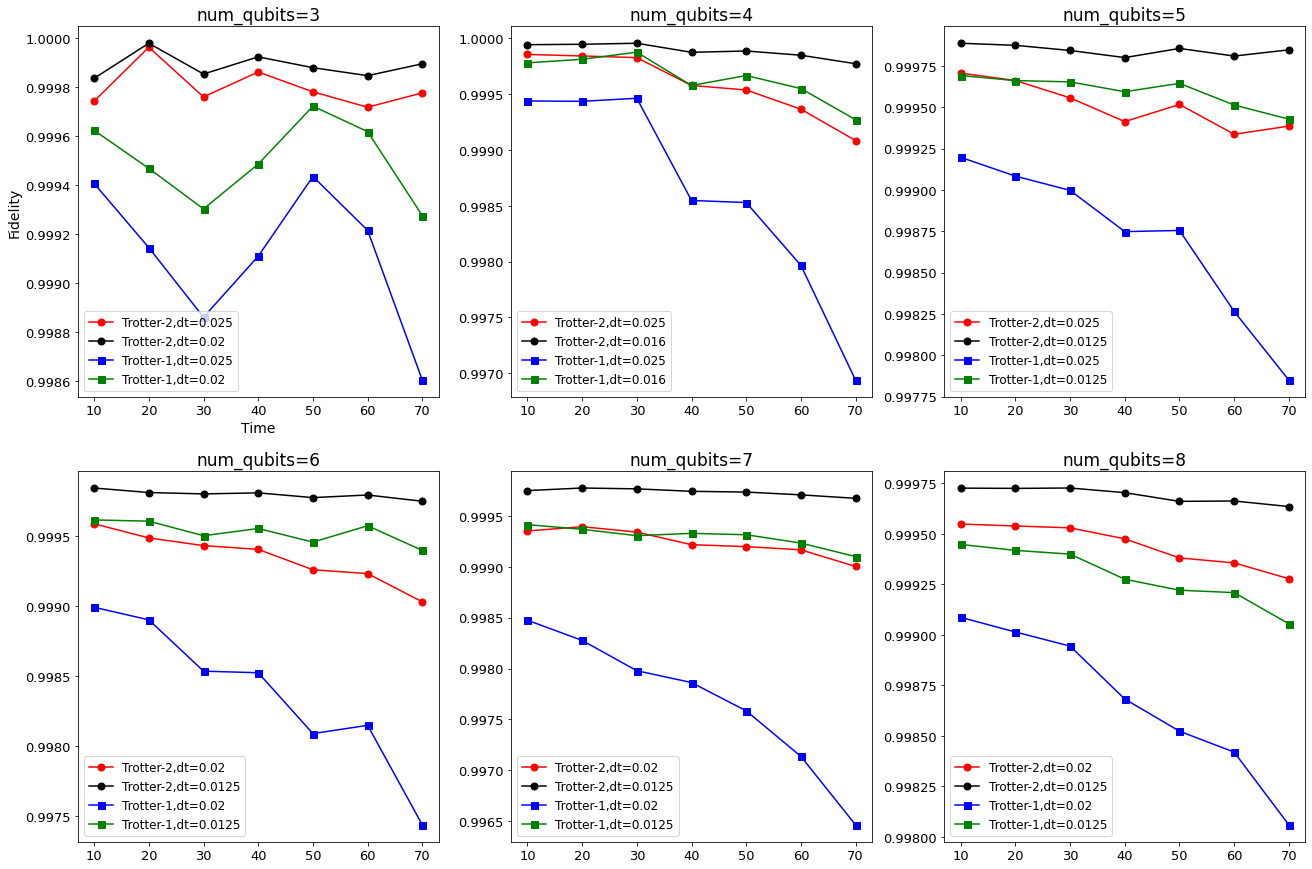

In [190]:
fig,ax=plt.subplots(2,3,figsize=(22,15))
ax[0,0].set_xlabel('Time',fontsize=14)
ax[0,0].set_ylabel('Fidelity',fontsize=14)
count=0
count1=0
for i in range(2):
    for j in range(3):
        #ax[i,j].set_yscale('log')
        ax[i,j].plot(Tarr,fidelity_fast_Trotter[count*len(Tarr):count*len(Tarr)+len(Tarr)],marker='o',markersize=7,color='red',label='Trotter-2,dt=%s'%str(DictNumQubitsAndTimeIntervals[count1+3][0]))
        ax[i,j].plot(Tarr,fidelity_fast_Trotter[count*len(Tarr)+len(Tarr):count*len(Tarr)+2*len(Tarr)],marker='o',markersize=7,color='black',label='Trotter-2,dt=%s'%str(DictNumQubitsAndTimeIntervals[count1+3][1]))
        ax[i,j].plot(Tarr,fidelity_conv_Trotter[count*len(Tarr):count*len(Tarr)+len(Tarr)],marker='s',markersize=7,color='blue',label='Trotter-1,dt=%s'%str(DictNumQubitsAndTimeIntervals[count1+3][0]))
        ax[i,j].plot(Tarr,fidelity_conv_Trotter[count*len(Tarr)+len(Tarr):count*len(Tarr)+2*len(Tarr)],marker='s',markersize=7,color='green',label='Trotter-1,dt=%s'%str(DictNumQubitsAndTimeIntervals[count1+3][1]))
        ax[i,j].set_title('num_qubits=%s'%(count1+3),fontsize=17)
        ax[i,j].tick_params(labelsize=13)
        ax[i,j].set_xticks([10,20,30,40,50,60,70])
        ax[i,j].legend(fontsize=12,loc='best')
        count=count+2
        count1=count1+1

**Fig:** Trotter-2 corresponds to the circuit where the XY Hamiltonian is fast-forwarded. And Trotter-1 is the circuit corresponds to the 1st order Trotter circuit.

## 4. Resource Estimation for high fidelity Quantum simulation (>99.9%) of time evolved states and its scaling with number of qubits
Resource estimation for quantum circuits corresponds to calculating circuit depth, number of CNOT gates etc. Below we construct methods to calculate the number of **CNOT gates** required for evolving via Trotter circuits for the XXZ spin model over a time period of evolution T. Our target is to estimate the **Quantum Resources** required to do quantum simulation of high fidelity(**>99.9%**) states evolved for long times (**T=70s**) with Trotterized circuits.

We perform resource estimation for the two kinds of Trotter circuit, below we calculate the number of CNOTS required for each single Trotter step using (1)1st order Trotter Circuit and (2)fast forwarded Trotter circuit,

(i) <span style="color:#FFA500">The conventional 1st order Trotter Circuit</span> for **n-qubit XXZ model Hamiltonian** has (n-1) XX, (n-1) YY and (n-1) ZZ Pauli Strings, altogether 3(n-1) Pauli Strings. Each two operator Pauli String is made of 2 CNOT gates. As a result a **single Trotter step** requires 6(n-1) CNOT gates.

(ii) <span style="color:#0F9D58">The fast forwarded Trotter circuits</span> involves n(n-1)/2 CNOT gates arising from the **Givens rotations** to diagonalize the XY part of the Hamiltonian. And the rest (n-1) ZZ strings requires 2(n-1) CNOT gates. Resultingly a **single Trotter step** requires 2(n-1)+n(n-1)/2 CNOT gates.

In [191]:
def resource_estimation_conv_1st_order_Trotter(num_qubits,t,T):
    num_of_terms=3*num_qubits
    num_of_CXs=2*num_of_terms# single Trotter step
    steps=int(T/t)
    return num_of_CXs*steps
def resource_estimation_fast_forward_Trotter(num_qubits,t,T):
    num_of_CXs_XY=num_qubits*(num_qubits-1)
    num_of_CXs_ZZ=2*(num_qubits-1)
    num_of_CXs=num_of_CXs_XY+num_of_CXs_ZZ #per Trotter step
    steps=int(T/t)
    return num_of_CXs*steps

In [192]:
numCNOTsFor1stOrderTrotter=[resource_estimation_conv_1st_order_Trotter(num_qubits,DictNumQubitsAndTimeIntervals[num_qubits][1],Tarr[-1]) for num_qubits in num_qubits_arr]
numCNOTsForFastForwardTrotter=[resource_estimation_fast_forward_Trotter(num_qubits,DictNumQubitsAndTimeIntervals[num_qubits][0],Tarr[-1]) for num_qubits in num_qubits_arr]

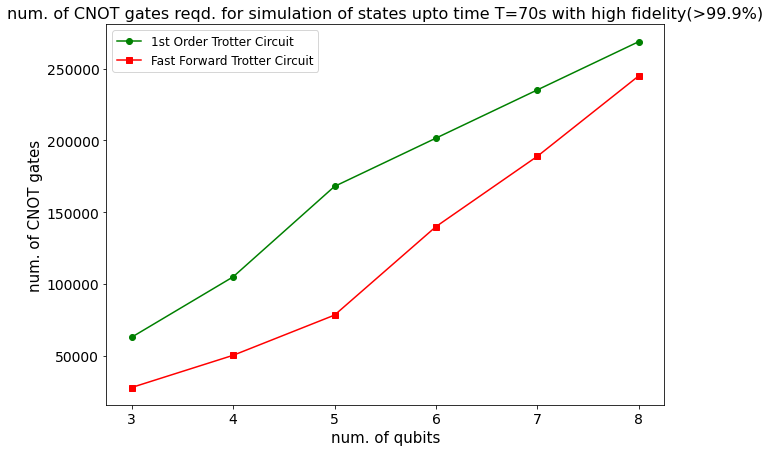

In [193]:
fig,ax=plt.subplots(1,figsize=(10,7))
ax.tick_params(labelsize=14)
ax.set_xlabel('num. of qubits',fontsize=15)
ax.set_ylabel('num. of CNOT gates',fontsize=15)
ax.set_title('num. of CNOT gates reqd. for simulation of states upto time T=70s with high fidelity(>99.9%)',fontsize=16)
ax.plot(num_qubits_arr,numCNOTsFor1stOrderTrotter,marker='o',color='g',label='1st Order Trotter Circuit')
ax.plot(num_qubits_arr,numCNOTsForFastForwardTrotter,marker='s',color='r',label='Fast Forward Trotter Circuit')
plt.legend(fontsize=12)